## Load Modules

In [1]:
import numpy as np
import lanfactory
from lanfactory.trainers.torch_mlp import LoadTorchMLPInfer
import ssms
import pandas as pd
import pickle
from copy import deepcopy

import os
#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=12'

import torch
from lanfactory.trainers.torch_mlp import TorchMLP  

import arviz as az
from time import time
import scipy

import matplotlib
import matplotlib.pyplot as plt

import jax
#jax.config.update('jax_platform_name', 'cpu')
from jax import numpy as jnp

import math
from numbers import Real
from numbers import Number

import numpyro as npy
from numpyro import distributions as dist
from numpyro.distributions import constraints

2022-09-18 16:26:36.110562: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/users/afengler/data/software/miniconda3/envs/pymc-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Utilies

In [2]:
network_files = {'network_config': {'ddm': 'd27193a4153011ecb76ca0423f39a3e6_ddm_torch__network_config.pickle',
                                    'angle': 'eba53550128911ec9fef3cecef056d26_angle_torch__network_config.pickle',
                                    'weibull': '44deb16a127f11eca325a0423f39b436_weibull_torch__network_config.pickle',
                                    'levy': '80dec298152e11ec88b8ac1f6bfea5a4_levy_torch__network_config.pickle'},
                 'network': {'ddm': 'd27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt',
                             'angle': 'eba53550128911ec9fef3cecef056d26_angle_torch_state_dict.pt',
                             'weibull': '44deb16a127f11eca325a0423f39b436_weibull_torch_state_dict.pt',
                             'levy': '80dec298152e11ec88b8ac1f6bfea5a4_levy_torch_state_dict.pt'}
                }

initial_params_jax_dict =  {'ddm': {'v': jnp.array([2.0, 2.0]),
                                    'a': jnp.array([1.0, 1.0]),
                                    'z': jnp.array([0.5, 0.5]),
                                    't': jnp.array([1.0, 1.0])
                                   },
                            'angle': {'v': jnp.array([0.5, 0.5]),
                                      'a': jnp.array([1.5, 1.5]),
                                      'z': jnp.array([0.5, 0.5]),
                                      't': jnp.array([1.0, 1.0]),
                                      'theta': jnp.array([0.5, 0.5])
                                     },
                            'weibull': {'v': jnp.array([0.5, 0.5]),
                                        'a': jnp.array([1.5, 1.5]),
                                        'z': jnp.array([0.5, 0.5]),
                                        't': jnp.array([1.0, 1.0]),
                                        'alpha': jnp.array([2.0, 2.0]),
                                        'beta': jnp.array([2.0, 2.0]),
                                       },
                            'levy': {'v': jnp.array([0.5, 0.5]),
                                     'a': jnp.array([1.5, 1.5]),
                                     'z': jnp.array([0.5, 0.5]),
                                     't': jnp.array([1.0, 1.0]),
                                     'alpha': jnp.array([1.5, 1.5]),
                                    }
                           }

In [3]:
class CustomTorchMLP:
    def __init__(self, state_dict, network_config):
        self.weights = []
        self.jnp_weights = []
        self.biases = []
        self.jnp_biases = []
        self.activations = deepcopy(network_config['activations'])
        self.net_depth = len(self.activations)
        self.state_dict = state_dict
        
        self.activation_dict_jax = {'tanh': jnp.tanh}
        self.activation_dict_torch = {'tanh': torch.tanh}
        cnt = 0
        
        for obj in self.state_dict:
            if 'weight' in obj:
                self.weights.append(deepcopy(self.state_dict[obj]).T)
                self.jnp_weights.append(jnp.asarray(self.weights[-1].numpy()))
            elif 'bias' in obj:
                self.biases.append(torch.unsqueeze(deepcopy(self.state_dict[obj]), 0))
                self.jnp_biases.append(jnp.asarray(self.biases[-1].numpy()))
                
    def forward(self, input_tensor):
        tmp = input_tensor
        for i in range(0, self.net_depth - 1, 1):
            tmp = torch.tanh(torch.add(torch.matmul(tmp, self.weights[i]), self.biases[i]))
        tmp = torch.add(torch.matmul(tmp, self.weights[self.net_depth - 1]), self.biases[self.net_depth - 1])
        return tmp
    
    def forward_jnp(self, input_array):
        tmp = input_array
        for i in range(0, self.net_depth - 1, 1):
            #tmp = jnp.tanh(jnp.dot(tmp, self.jnp_weights[i]) + (self.jnp_biases[i]))
            tmp = self.activation_dict_jax[self.activations[i]](jnp.dot(tmp, self.jnp_weights[i]) + (self.jnp_biases[i]))
        tmp = jnp.dot(tmp, self.jnp_weights[self.net_depth - 1]) + self.jnp_biases[self.net_depth - 1]
        return tmp

In [4]:
def load_network(model = 'ddm'):
    model_config = deepcopy(ssms.config.model_config[model])
    
    # Load network config
    network_config = pickle.load(open('nets/' + network_files['network_config'][model],
                                      'rb'))

    # Initialize network class
    torch_net = TorchMLP(network_config = network_config,
                   input_shape = model_config['n_params'] + 2,
                   generative_model_id = None)

    # Load weights and biases
    torch_net.load_state_dict(torch.load('nets/' + network_files['network'][model],
                              map_location=torch.device('cpu')))


    # Initialize custom pytorch network
    custom_torch_net = CustomTorchMLP(torch_net.state_dict(), 
                                      network_config)
    
    return custom_torch_net

In [5]:
import ssms
def sim_wrap(theta = None, model = 'ddm', n_samples = 1, output_format = 'torch'):
    theta = theta.squeeze()
    
    if theta.dim() == 3:
        out_lis
        t = []
        out_processed_list = []
        
        for i in range(theta.shape[0]):
            theta_tmp = theta[i, ...].numpy().astype(np.float32)
    
            out_tmp = ssms.basic_simulators.simulator(theta = theta_tmp,
                                                      model = model,
                                                      n_samples = n_samples,
                                                      delta_t = 0.001,
                                                      max_t = 20.0,
                                                      no_noise = False,
                                                      bin_dim = None,
                                                      bin_pointwise = False)
        
            out_processed_list.append(np.concatenate([out_tmp['rts'].astype(np.float32), 
                                                      out_tmp['choices'].astype(np.float32)], axis = -1))
            out = np.stack(out_processed_list)
            
        if output_format == 'torch':
            return torch.tensor(out)
        elif output_format == 'jax':
            return jnp.asarray(out)
        elif output_format == 'numpy':
            return out
        else:
            raise NotImplementedError("Unknown output_format supplied")
    elif (theta.dim() == 2) or (theta.dim() == 1):
        theta_tmp = theta.numpy().astype(np.float32)
        out_tmp = ssms.basic_simulators.simulator(theta = theta_tmp,
                                                  model = model,
                                                  n_samples = n_samples,
                                                  delta_t = 0.001,
                                                  max_t = 20.0,
                                                  no_noise = False,
                                                  bin_dim = None,
                                                  bin_pointwise = False)
        
        
        out = np.concatenate([out_tmp['rts'].astype(np.float32), 
                                                out_tmp['choices'].astype(np.float32)], axis = -1)
        
        if output_format == 'torch':
            return torch.tensor(out)
        elif output_format == 'jax':
            return jnp.asarray(np.stack(out))
        elif output_format == 'numpy':
            return out
        else: 
            raise NotImplementedError("Unknown out_format supplied")                       
    else:
        raise NotImplementedError("theta should be of dimensionality 2 or 3 after squeezing")

## Single Subject

In [152]:
# Model
from copy import deepcopy
model = "ddm" # for now only DDM (once we have choice probability models --> all models applicable)
model_config = ssms.config.model_config[model].copy() # convenience


central_data_single_subject = pickle.load(open('data/single_subject/' + model + \
                                               '_nsamples_1000_nparams_200_stdfracdenom_6.pickle', 'rb'))

subj_idx = 3
data = central_data_single_subject['data'][subj_idx]['numpyro']
gt_params = central_data_single_subject['data'][subj_idx]['gt_params']
n_samples = central_data_single_subject['data'][subj_idx]['numpyro'].shape[0]

network = load_network(model = model)

print(ssms.config.model_config[model])

tanh
tanh
linear
{'name': 'ddm', 'params': ['v', 'a', 'z', 't'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]], 'boundary': <function constant at 0x7f8c844901f0>, 'n_params': 4, 'default_params': [0.0, 1.0, 0.5, 0.001], 'hddm_include': ['z'], 'nchoices': 2}


In [153]:
class SSMDistJax(npy.distributions.Distribution):
    def __init__(self, params, network):
        self.net = network
        self.params = params
        
        if self.params.ndim == 1:
             batch_shape = (1,)
        elif self.params.ndim > 1:
            batch_shape = self.params.shape[:-1]
            
        super().__init__(batch_shape = batch_shape, event_shape = (2,))
        
    def sample(self, key, sample_shape = ()):
        raise NotImplementedError
    
    def log_prob(self, value):
        net_in = jnp.hstack([jnp.tile(self.params, ((value.shape[0], 1))), value])
        net_out = self.net.forward_jnp(net_in)
        out = jnp.squeeze(jnp.clip(net_out, a_min = -16.11))
        return out

In [154]:
def model_maker_jax(model = 'ddm'):
    model_config = ssms.config.model_config[model]
    
    def ssm_model_jax(num_trials, data, network):
        param_list = []
        for param in model_config['params']:
            idx = model_config['params'].index(param)
            param_list.append(npy.sample(param, dist.Uniform(model_config['param_bounds'][0][idx],
                                                             model_config['param_bounds'][1][idx])))
            #param_list.append(npy.sample(param, dist.Normal(model_config['default_params'][idx], 0.5)))
        with npy.plate("data", num_trials) as data_plate:
            return npy.sample("obs", SSMDistJax(jnp.stack(param_list, axis=-1), network), obs = data)
        
    return ssm_model_jax

In [155]:
numpyro_ssm_model = model_maker_jax(model = model)

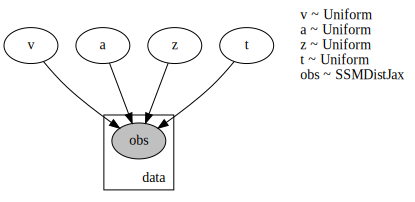

In [156]:
npy.render_model(numpyro_ssm_model, model_args = (n_samples, data, network), 
                 render_distributions = True, 
                 render_params = True)

### Sample Variational

In [158]:
from torch.distributions import transform_to
from functools import partial
import functools
from typing import Callable, Optional


from numpyro.distributions import biject_to
from numpyro.util import find_stack_level

def init_to_uniform_custom(
    site: Optional[dict] = None,
    radius: float = 0.1,
    ):
    """
    Initialize to a random point in the area ``(-radius, radius)`` of
    unconstrained domain.

    :param float radius: specifies the range to draw an initial point in the
        unconstrained domain.
    """
    print(site)
    
    if site is None:
        return functools.partial(init_to_uniform, radius=radius)
    
    rng_key = site["kwargs"].get("rng_key")
    
    # group level locs -------
    if site['name'] == 'v':
        return jax.random.uniform(key = rng_key) - 0.5
    
    if site['name'] == 'a':
        return (jax.random.uniform(key = rng_key) - 0.5) + 1.5
    
    if site['name'] == 'z':
        return (jax.random.uniform(key = rng_key) / 5) + 0.3
    
    if site['name'] == 't':
        return jax.random.uniform(key = rng_key) / 5
    
    if site['name'] == 'theta':
        return jax.random.uniform(key = rng_key) / 10

    # -------
    
    # std parameters keep the uniform random init
    #value = site["fn"].sample().detach()
    #t = transform_to(site["fn"].support)
    #value = t(torch.rand_like(t.inv(value)) * (2 * radius) - radius)
    #value._pyro_custom_init = False
    
    
def init_to_uniform(site=None, radius=2):
    """
    Initialize to a random point in the area `(-radius, radius)` of unconstrained domain.

    :param float radius: specifies the range to draw an initial point in the unconstrained domain.
    """
    if site is None:
        return partial(init_to_uniform, radius=radius)

    if (
        site["type"] == "sample"
        and not site["is_observed"]
        and not site["fn"].support.is_discrete
    ):
        if site["value"] is not None:
            warnings.warn(
                f"init_to_uniform() skipping initialization of site '{site['name']}'"
                " which already stores a value.",
                stacklevel=find_stack_level(),
            )
            return site["value"]

        # XXX: we import here to avoid circular import
        from numpyro.infer.util import helpful_support_errors

        rng_key = site["kwargs"].get("rng_key")
        sample_shape = site["kwargs"].get("sample_shape")

        with helpful_support_errors(site):
            transform = biject_to(site["fn"].support)
        unconstrained_shape = transform.inverse_shape(site["fn"].shape())
        unconstrained_samples = dist.Uniform(-radius, radius)(
            rng_key=rng_key, sample_shape=sample_shape + unconstrained_shape
        )
        return transform(unconstrained_samples)


In [159]:
#from numpyro.infer.initialization import init_to_median
auto_guide = npy.infer.autoguide.AutoMultivariateNormal(numpyro_ssm_model, 
                                                        init_scale = 0.02, 
                                                        init_loc_fn = init_to_uniform_custom) #init_to_uniform_custom)


In [160]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
from jax import random, vmap


optimizer = npy.optim.Adam(step_size = 0.02)
svi = SVI(numpyro_ssm_model, 
          auto_guide, 
          optimizer, 
          loss=Trace_ELBO(num_particles = 1))

#svi_state = svi.init(random.PRNGKey(10), *(n_samples, out, network))

# params_list = []
# for step in range(100):
#     print(svi.get_params(svi_state))
#     svi_state, loss = svi.update(svi_state,  *(n_samples, out, network))
#     if step % 10 == 0:
#         print("Step {} out of {}, Elbo loss: {}".format(step, 200, loss))
#     params_list.append(svi.get_params(svi_state)) 
    
svi_result = svi.run(random.PRNGKey(0), 5000, *(n_samples, data, network))

{'type': 'sample', 'name': 'v', 'fn': <numpyro.distributions.continuous.Uniform object at 0x7f8bdd41f220>, 'args': (), 'kwargs': {'rng_key': DeviceArray([3571746123, 1779671943], dtype=uint32), 'sample_shape': ()}, 'value': None, 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}
{'type': 'sample', 'name': 'a', 'fn': <numpyro.distributions.continuous.Uniform object at 0x7f8c251416d0>, 'args': (), 'kwargs': {'rng_key': DeviceArray([3938622906, 1817657134], dtype=uint32), 'sample_shape': ()}, 'value': None, 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}
{'type': 'sample', 'name': 'z', 'fn': <numpyro.distributions.continuous.Uniform object at 0x7f8c00d33e80>, 'args': (), 'kwargs': {'rng_key': DeviceArray([1107319103, 4132708090], dtype=uint32), 'sample_shape': ()}, 'value': None, 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}
{'type': 'sample', 'name'

100%|██████████| 5000/5000 [00:03<00:00, 1262.00it/s, init loss: 2034.8542, avg. loss [4751-5000]: 1430.4839]


In [162]:
svi_result

SVIRunResult(params={'auto_loc': DeviceArray([-0.7650385 ,  0.7792974 ,  0.27593583, -0.1477226 ], dtype=float32), 'auto_scale_tril': DeviceArray([[ 0.03046852,  0.        ,  0.        ,  0.        ],
             [-0.03766878,  0.08914268,  0.        ,  0.        ],
             [-0.05585174, -0.03217646,  0.07149306,  0.        ],
             [ 0.03538565, -0.03442485, -0.03518507,  0.03306707]],            dtype=float32)}, state=SVIState(optim_state=(DeviceArray(5000, dtype=int32, weak_type=True), OptimizerState(packed_state=([DeviceArray([-0.7650385 ,  0.7792974 ,  0.27593583, -0.1477226 ], dtype=float32), DeviceArray([ -9.951227,  -8.310844, -13.002206, -21.50783 ], dtype=float32), DeviceArray([4972.988  ,  578.442  ,  918.89636, 1587.1711 ], dtype=float32)], [DeviceArray([-0.4225673 , -0.78121907, -0.45006418,  1.0701172 ,
             -1.0410614 , -1.0640514 , -3.4757884 , -2.3726146 ,
             -2.6021955 , -3.3926382 ], dtype=float32), DeviceArray([-1.083302  , -1.1412125 

In [163]:
predictive = Predictive(numpyro_ssm_model, 
                        guide = auto_guide,
                        num_samples = 1000)

predictive(random.PRNGKey(0), *(n_samples, data, network))

{'obs': DeviceArray([[[ 3.6801255, -1.       ],
               [ 2.466158 , -1.       ],
               [ 2.4861588, -1.       ],
               ...,
               [ 2.2911496, -1.       ],
               [ 2.643166 , -1.       ],
               [ 7.650838 , -1.       ]],
 
              [[ 3.6801255, -1.       ],
               [ 2.466158 , -1.       ],
               [ 2.4861588, -1.       ],
               ...,
               [ 2.2911496, -1.       ],
               [ 2.643166 , -1.       ],
               [ 7.650838 , -1.       ]],
 
              [[ 3.6801255, -1.       ],
               [ 2.466158 , -1.       ],
               [ 2.4861588, -1.       ],
               ...,
               [ 2.2911496, -1.       ],
               [ 2.643166 , -1.       ],
               [ 7.650838 , -1.       ]],
 
              ...,
 
              [[ 3.6801255, -1.       ],
               [ 2.466158 , -1.       ],
               [ 2.4861588, -1.       ],
               ...,
               [ 2.291

### Sample NUTS

In [173]:
# NUTS VERSION
from numpyro.infer import MCMC, NUTS
from jax import random, vmap

nuts_kernel = NUTS(numpyro_ssm_model) #, jit_compile = True, ignore_jit_warnings = True) #, step_size = 1, max_tree_depth = 1)
                   #jit_compile = True,
                   #ignore_jit_warnings = True) # step_size = 1, max_tree_depth = 1)
mcmc = MCMC(nuts_kernel, num_samples = 1000, num_warmup = 1000, num_chains = 2)  

rng_key = random.PRNGKey(20)
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, n_samples, data, network, init_params = initial_params_jax_dict[model])
mcmc_az = az.from_numpyro(mcmc)
traces_dict = mcmc.get_samples(group_by_chain = True)

/tmp/ipykernel_23717/85485715.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples = 1000, num_warmup = 1000, num_chains = 2)
sample: 100%|██████████| 2000/2000 [00:15<00:00, 133.27it/s, 15 steps of size 2.65e-01. acc. prob=0.94]


In [177]:
# Make folder for arviz data if it doesn't already exist
arviz_path = 'data/single_subject/' + \
             model + '_nsamples_1000_nparams_200_stdfracdenom_6'

pathlib.Path(arviz_path).mkdir(parents = True, 
                               exist_ok = True)

pickle.dump(mcmc_az, open(arviz_path + '/arviz_mcmc_numpyro_' + \
                          str(dataset_idx) + '.pickle', 'wb'))
pickle.dump(traces_dict, open(arviz_path + '/dict_mcmc_numpyro_' + \
                                      str(dataset_idx) + '.pickle', 'wb'))

{'a': DeviceArray([[1.8571424, 1.8288903, 1.7808323, ..., 1.9917924, 1.7012863,
               1.7167137],
              [1.7678525, 1.7360566, 1.7322254, ..., 1.8173468, 1.6872442,
               1.9293816]], dtype=float32),
 't': DeviceArray([[0.83396643, 0.8616177 , 0.95200187, ..., 0.8920203 ,
               0.95686746, 0.9429405 ],
              [0.9357065 , 0.9358798 , 0.92444956, ..., 0.9557983 ,
               1.0055866 , 0.8357181 ]], dtype=float32),
 'v': DeviceArray([[-1.1079459, -1.0873892, -1.1063851, ..., -1.1512063,
               -1.1059792, -1.0826724],
              [-1.1230448, -1.0242194, -0.9920621, ..., -1.0280855,
               -1.0275346, -1.1464798]], dtype=float32),
 'z': DeviceArray([[0.5917169 , 0.5727521 , 0.551689  , ..., 0.5364364 ,
               0.5731855 , 0.57026887],
              [0.57514894, 0.5587486 , 0.54841465, ..., 0.5151954 ,
               0.52827233, 0.5698268 ]], dtype=float32)}

In [104]:
gt_params

{'v': 0.740486635742288,
 'a': 1.684371956287384,
 'z': 0.4916486735689587,
 't': 0.8021088234457727}

array([[<AxesSubplot:ylabel='t'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='v'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a', ylabel='z'>, <AxesSubplot:xlabel='t'>,
        <AxesSubplot:xlabel='v'>]], dtype=object)

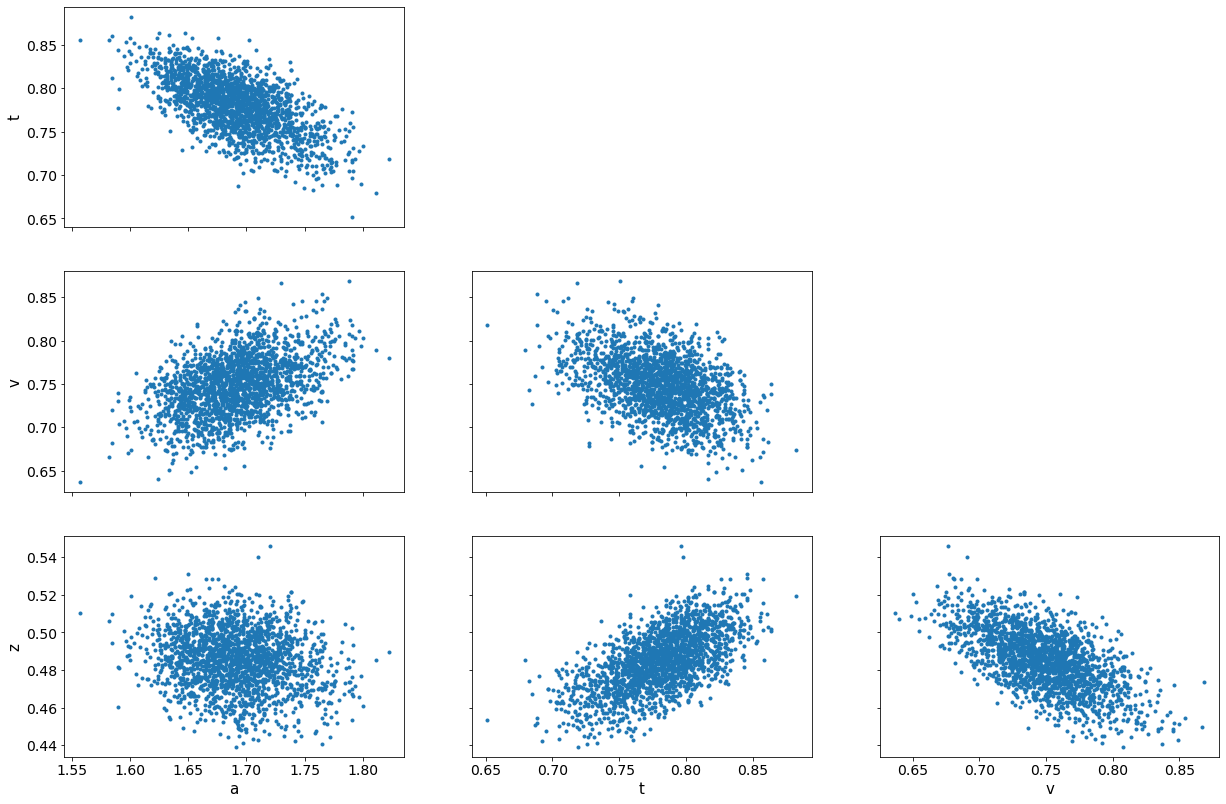

In [105]:
az.plot_pair(mcmc_az)

In [165]:
mcmc_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Hierarchical

In [6]:
model = 'ddm'
model_config = ssms.config.model_config[model]

central_data_hierarchical = pickle.load(open('data/hierarchical/' + model + \
                                             '_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6.pickle', 'rb'))

dataset_idx = 0
data = central_data_hierarchical['data'][dataset_idx]['numpyro']
gt_params = central_data_hierarchical['data'][dataset_idx]['gt_params']
n_samples = central_data_hierarchical['data'][dataset_idx]['numpyro'].shape[0]
n_subjects = central_data_hierarchical['data'][dataset_idx]['numpyro'].shape[1]

network = load_network(model = model)

print(ssms.config.model_config[model])

tanh
tanh
linear
{'name': 'ddm', 'params': ['v', 'a', 'z', 't'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]], 'boundary': <function constant at 0x7f043a9db1f0>, 'n_params': 4, 'default_params': [0.0, 1.0, 0.5, 0.001], 'hddm_include': ['z'], 'nchoices': 2}


In [7]:
def model_maker_hierarchical_jax(model = 'ddm'):
    model_config = deepcopy(ssms.config.model_config[model])
    model_config['mu_mu_std'] = {'ddm': {'v': 0.5,
                                         'a': 0.5,
                                         'z': 0.5,
                                         't': 0.5}
                                }
    def ssm_model_hierarchical(num_subjects, num_trials, data, network, ssm_name):
        mu_mu_list = []
        mu_std_list = []
        for param in model_config['params']:
            idx = model_config['params'].index(param)
            param_mean = (model_config['param_bounds'][1][idx] + model_config['param_bounds'][0][idx]) / 2
            mu_mu_list.append(npy.sample(param + "_mu_mu", 
                                         dist.Normal(param_mean, 
                                                     model_config['mu_mu_std'][model][param])
                                        )
                             )
            mu_std_list.append(npy.sample(param + "_mu_std",
                                          dist.HalfNormal(100.)
                                         )
                              )
                              
                              
        with npy.plate("subjects", num_subjects) as subjects_plate:
            subj_list = []
            
            for param in model_config['params']:
                idx = model_config['params'].index(param)
                subj_list.append(npy.sample(param + "_subj", dist.Normal(mu_mu_list[idx], mu_std_list[idx])
                                           )
                                )
            with npy.plate("data", num_trials) as data_plate:
                return npy.sample("obs",
                                  MyDDMh_new(jnp.stack(subj_list, axis = -1), num_trials, network, ssm_name),
                                  obs = data)
    return ssm_model_hierarchical                              

In [8]:
ssm_model_hierarchical = model_maker_hierarchical_jax(model = model)

In [9]:
### Hierarchicalimport math
from numbers import Real
from numbers import Number

# Load network config
network_config = pickle.load(open('nets/' + network_files['network_config'][model],
                                  'rb'))

# Initialize network class
torch_net = TorchMLP(network_config = network_config,
               input_shape = model_config['n_params'] + 2,
               generative_model_id = None)

# Load weights and biases
torch_net.load_state_dict(torch.load('nets/' + network_files['network'][model],
                          map_location=torch.device('cpu')))


# Initialize custom pytorch network
custom_torch_net = CustomTorchMLP(torch_net.state_dict(), 
                                  network_config)

# Test forward pass
custom_torch_net.forward(torch.randn((10, model_config['n_params'] + 2)))

# 
network = custom_torch_net

class MyDDMh_new(npy.distributions.Distribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, params, num_trials, network, ssm_name):
        self.net = network
        self.n_samples = num_trials
        self.boundaries = ssms.config.model_config[ssm_name]['param_bounds']
        self.out_of_bounds_val = -66.1
        self.params = params
        self.params_size = self.params.shape
        self.n_params = ssms.config.model_config[ssm_name]['n_params']
        self.ssm_name = ssm_name
        self.params_shape = self.params.shape 
        super().__init__(batch_shape = self.params_shape[:-1], 
                         event_shape = (2,)) #torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        raise NotImplementedError
    
    def log_prob(self, value):
        if self.params.ndim == 3:
            tmp_dat = jnp.tile(value, reps = (self.params_size[0], 1, 1, 1))
            tmp_params = jnp.tile(self.params, reps = (1, self.n_samples, 1, 1))
        else:
            tmp_params = jnp.tile(self.params, reps = (self.n_samples, 1, 1))
            tmp_dat = value

        net_in = jnp.concatenate([tmp_params, tmp_dat], axis = -1)
        net_out = self.net.forward_jnp(net_in)
        logp_squeezed = jnp.squeeze(jnp.clip(net_out, a_min = -16.11))

        for i in range(self.n_params):
            logp_squeezed = jnp.where(net_in[..., i] < self.boundaries[1][i], 
                                      logp_squeezed, 
                                      self.out_of_bounds_val)
            logp_squeezed = jnp.where(net_in[..., i] > self.boundaries[0][i], 
                                      logp_squeezed, 
                                      self.out_of_bounds_val)
        return logp_squeezed

tanh
tanh
linear


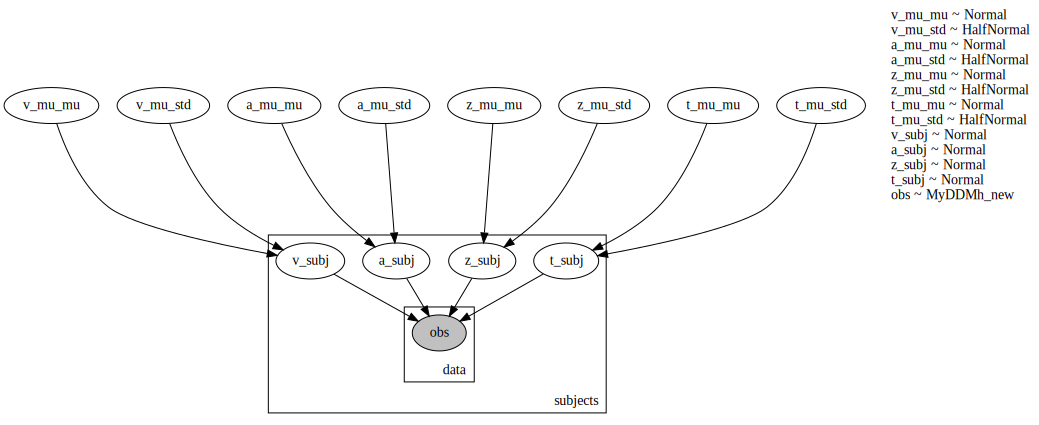

In [10]:
npy.render_model(ssm_model_hierarchical, 
                  model_args = (n_subjects, 
                                n_samples, 
                                data,
                                network,
                                'ddm'), 
                  render_distributions = True, 
                  render_params = True)

In [115]:
# NUTS VERSION
from numpyro.infer import MCMC, NUTS
from jax import random, vmap

init_params_dict_auto = {key_: gt_params[key_] for key_ in gt_params.keys()}
nuts_kernel = NUTS(ssm_model_hierarchical) 
mcmc = MCMC(nuts_kernel, 
            num_samples = 2000, 
            num_warmup = 2000, 
            num_chains = 1)  

# With JAX we have to raise random 
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, 
         *(n_subjects, n_samples, data, network, 'ddm'), # model parameter
         init_params = init_params_dict_auto # other parameters
        )

mcmc_az = az.from_numpyro(mcmc)
traces_dict = mcmc.get_samples(group_by_chain = True)

sample: 100%|██████████| 4000/4000 [03:14<00:00, 20.61it/s, 15 steps of size 2.49e-01. acc. prob=0.90]   


In [ ]:
# Make folder for arviz data if it doesn't already exist
arviz_path = 'data/hierarchical/' + \
             model + '_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6'

pathlib.Path(arviz_path).mkdir(parents = True, 
                               exist_ok = True)

pickle.dump(mcmc_az, open(arviz_path + '/arviz_mcmc_numpyro_' + \
                          str(dataset_idx) + '.pickle', 'wb'))
pickle.dump(traces_dict, open(arviz_path + '/dict_mcmc_numpyro_' + \
                                      str(dataset_idx) + '.pickle', 'wb'))

In [116]:
mcmc_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:ylabel='a_subj\n4'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='z_subj\n4'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v_subj\n4', ylabel='t_subj\n4'>,
        <AxesSubplot:xlabel='a_subj\n4'>,
        <AxesSubplot:xlabel='z_subj\n4'>]], dtype=object)

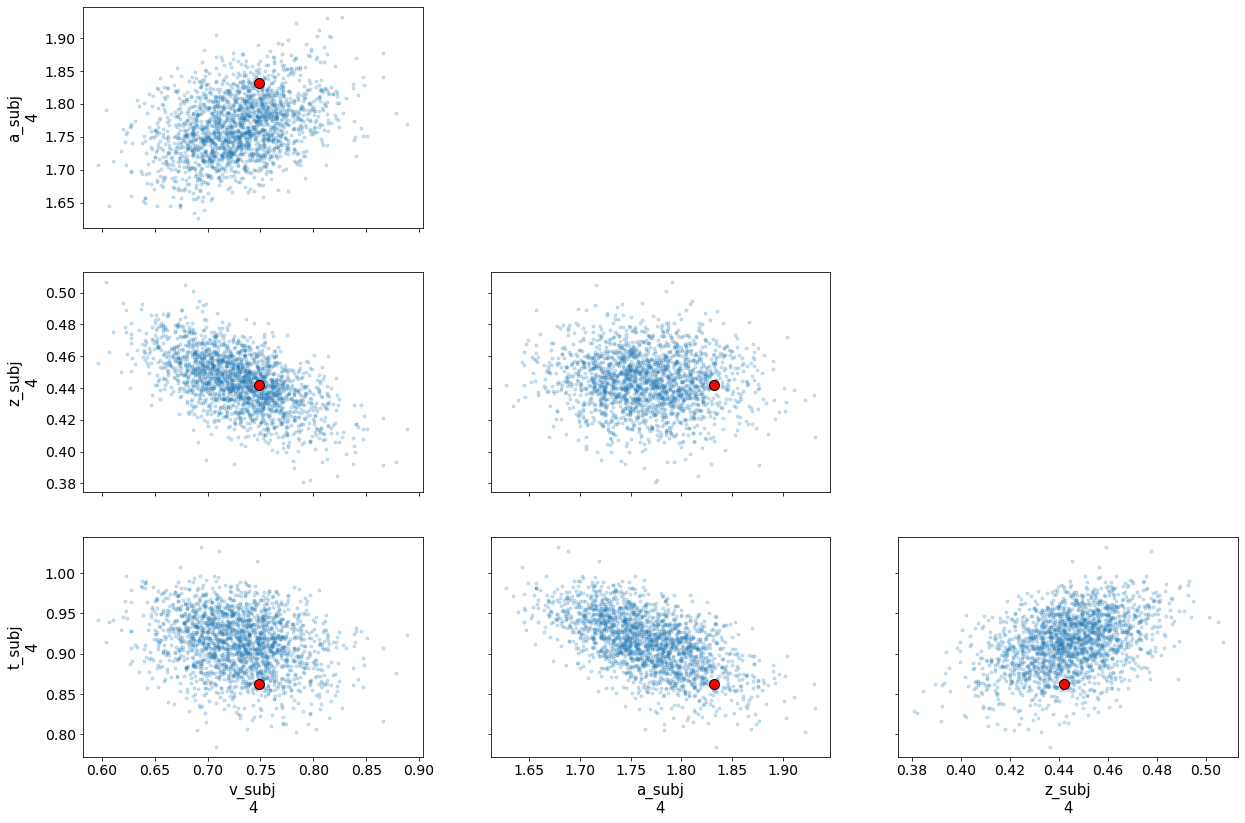

In [121]:
subj_id = 4
az.plot_pair(mcmc_az, 
             var_names = ['v_subj', 'a_subj', 'z_subj', 't_subj'], 
             scatter_kwargs = {'alpha': 0.2},
             coords = {'t_subj_dim_0': [subj_id],
                      'a_subj_dim_0': [subj_id],
                      'z_subj_dim_0': [subj_id],
                      'v_subj_dim_0': [subj_id]},
             reference_values = {'v_subj ' + str(subj_id): gt_params['v_subj'][subj_id],
                                 'a_subj ' + str(subj_id): gt_params['a_subj'][subj_id],
                                 't_subj ' + str(subj_id): gt_params['t_subj'][subj_id],
                                 'z_subj ' + str(subj_id): gt_params['z_subj'][subj_id]},
             reference_values_kwargs = {'color': 'red',
                                        'marker': 'o',
                                        'ms': 10})

array([[<AxesSubplot:ylabel='a_mu_mu'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='z_mu_mu'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v_mu_mu', ylabel='t_mu_mu'>,
        <AxesSubplot:xlabel='a_mu_mu'>, <AxesSubplot:xlabel='z_mu_mu'>]],
      dtype=object)

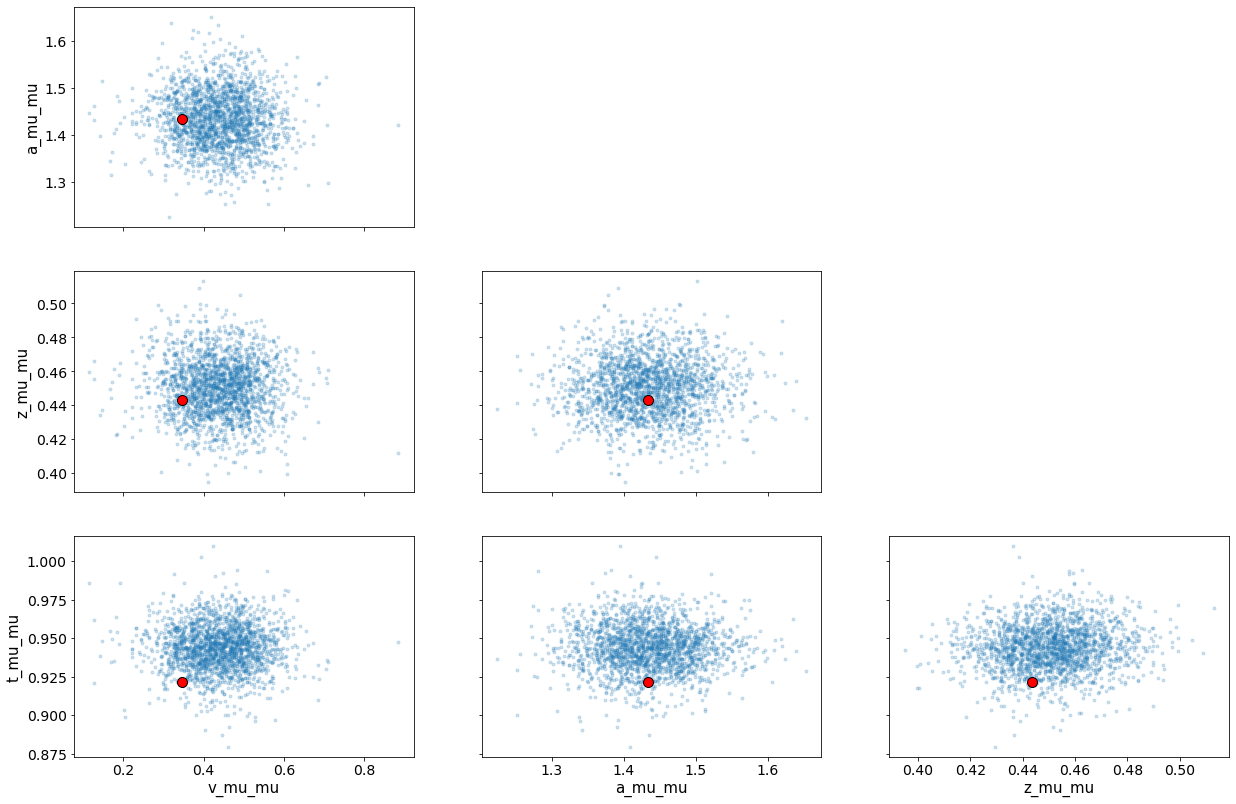

In [123]:
az.plot_pair(mcmc_az, 
             var_names = ['v_mu_mu', 'a_mu_mu', 'z_mu_mu', 't_mu_mu'], 
             scatter_kwargs = {'alpha': 0.2},
             reference_values = {'v_mu_mu': gt_params['v_mu_mu'],
                                 'a_mu_mu': gt_params['a_mu_mu'],
                                 't_mu_mu': gt_params['t_mu_mu'],
                                 'z_mu_mu': gt_params['z_mu_mu'],
                                },
             reference_values_kwargs = {'color': 'red',
                                        'marker': 'o',
                                        'ms': 10})

array([[<AxesSubplot:ylabel='a_mu_std'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='z_mu_std'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v_mu_std', ylabel='t_mu_std'>,
        <AxesSubplot:xlabel='a_mu_std'>, <AxesSubplot:xlabel='z_mu_std'>]],
      dtype=object)

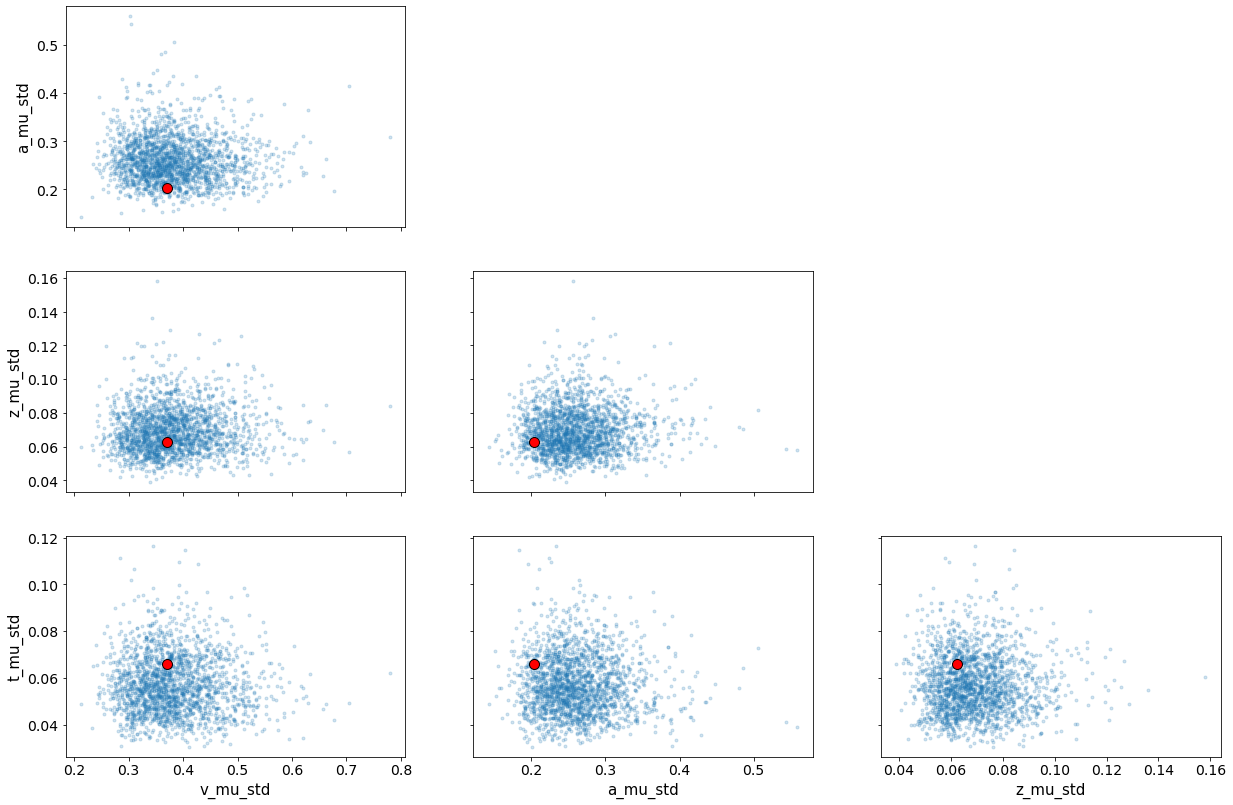

In [124]:
az.plot_pair(mcmc_az, 
             var_names = ['v_mu_std', 'a_mu_std', 'z_mu_std', 't_mu_std'], 
             scatter_kwargs = {'alpha': 0.2},
             reference_values = {'v_mu_std': gt_params['v_mu_std'],
                                 'a_mu_std': gt_params['a_mu_std'],
                                 't_mu_std': gt_params['t_mu_std'],
                                 'z_mu_std': gt_params['z_mu_std'],
                                },
             reference_values_kwargs = {'color': 'red',
                                        'marker': 'o',
                                        'ms': 10})